# Asymmetric Reactivity Ramp

## Helper Functions

In [1]:
import xml.etree.ElementTree as ET
from xml.dom import minidom

class Precursor:
    def __init__(self, decay_constant, beta):
        self.decay_constant = decay_constant
        self.beta = beta
        
class Precomp:
    def __init__(self, time, power, rho, concentrations):
        self.time = time
        self.power = power
        self.rho  = rho
        self.concentrations = concentrations
        
class Params:
    def __init__(self, time, rho_imp, lambda_h, gen_time,
                 pow_norm, beta_sum, theta, gamma_d, eta,
                 interpolated):
        self.time = time
        self.rho_imp = rho_imp
        self.lambda_h = lambda_h
        self.gen_time = gen_time
        self.pow_norm = pow_norm
        self.beta_sum = beta_sum
        self.theta = theta
        self.gamma_d = gamma_d
        self.eta = eta
        self.interpolated = interpolated

def write_input_xml(precomp, params, precursors):
    parareal = ET.Element("parareal", 
                          outpath="examples/epke_output.xml", 
                          max_iterations=str(2), 
                          n_fine_per_coarse=str(2))
    
    # epke precomputed values (initial conditions)
    epke_output = ET.SubElement(parareal,"epke_output", n_steps=str(len(precomp.time)))
    ET.SubElement(epke_output, "time").text = ' '.join(map(str,precomp.time))
    ET.SubElement(epke_output, "power").text = ' '.join(map(str,precomp.power))
    ET.SubElement(epke_output, "rho").text = ' '.join(map(str,precomp.rho))
    concentrations_element = ET.SubElement(epke_output, "concentrations")
    
    # epke parameters
    epke_input = ET.SubElement(parareal,"epke_input", 
                               n_steps=str(len(params.time)), 
                               theta=str(params.theta), 
                               gamma_d=str(params.gamma_d),
                               eta=str(params.gamma_d), 
                               interpolated=str(params.interpolated).lower())
    
    ET.SubElement(epke_input, "time").text = ' '.join(map(str, params.time))
    ET.SubElement(epke_input, "rho_imp").text = ' '.join(map(str, params.rho_imp))
    
    if (params.gen_time is not None):
        ET.SubElement(epke_input, "gen_time").text = ' '.join(map(str, params.gen_time))
    else:
        ET.SubElement(epke_input, "gen_time", value="1.58e-5")
    
    if (params.pow_norm is not None):
        ET.SubElement(epke_input, "pow_norm").text = ' '.join(map(str, params.pow_norm))
    else:
        ET.SubElement(epke_input, "pow_norm", value="1.0")
    
    ET.SubElement(epke_input, "beta_eff", value=str(params.beta_sum))
    ET.SubElement(epke_input, "lambda_h").text = ' '.join(map(str,params.lambda_h))
    
    precursors_element = ET.SubElement(epke_input, "precursors")
    for k, precursor in enumerate(precursors):
        precursor_element = ET.SubElement(precursors_element, "precursor", k=str(k))
        ET.SubElement(precursor_element, "decay_constant", value=str(precursor.decay_constant))
        ET.SubElement(precursor_element, "delayed_fraction", value=str(precursor.beta))
        ET.SubElement(concentrations_element, "concentration", 
                      k=str(k)).text = ' '.join(map(str, precomp.concentrations[k])) 
    
    # pretty print and write to xml
    xmlstr = minidom.parseString(ET.tostring(parareal)).toprettyxml(indent=" ")
    
    with open("epke_input.xml", "w") as f:
        f.write(xmlstr)

## Generate the Input Data

In [2]:
import numpy as np

precursors = [Precursor(0.49405, 0.0076)]
beta_sum = sum([p.beta for p in precursors])

t_end = 6
t_step = 1000 # number of time steps
t = np.linspace(0,t_end,t_end*t_step+1)

up = .5 # $/s (upwards reactivity ramp)
down = .1 # $/s (downwards reactivity ramp)
t1 = 1
t1_i = round(t1*t_step) # index of t1
rho_imp = np.zeros(len(t))
rho_imp[:(t1_i+1)] = up*t[:(t1_i+1)]
rho_imp[(t1_i+1):] = up*t1 - down*(t[(t1_i+1):] - t1)

beta_eff = beta_sum * np.ones(len(t))
rho_imp = rho_imp * beta_sum
gen_time = 2.6e-15 * np.ones(len(t))
lambduh_h = np.ones(len(t))
pow_norm = np.ones(len(t))
theta = 0.5
eta = 1.0
gamma_d = 0.0
interpolated = True

params = Params(t, rho_imp, lambduh_h, gen_time, 
                pow_norm, beta_sum, theta, gamma_d, 
                eta, interpolated)

# generate the initial conditions
precomp_time = [0.0]
precomp_power = [1.0]
precomp_rho = [rho_imp[0]]
precomp_concentrations = []

for j, precursor in enumerate(precursors):
    initial_concentration = precursor.beta*precomp_power[0]/precursor.decay_constant
    precomp_concentrations.append([initial_concentration])

precomp = Precomp(precomp_time, precomp_power, 
                  precomp_rho, precomp_concentrations)
    
# write to xml
write_input_xml(precomp, params, precursors)

## Run the EPKE Executable

In [3]:
import subprocess

args = "./epke-run examples/epke_input.xml".split()
popen = subprocess.Popen(args, cwd="..", stdout=subprocess.PIPE)
popen.wait()
while True:
    line = popen.stdout.readline()
    if not line:
        break
    print(line.rstrip().decode('utf-8'))

Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml


## Read the XML Output

In [4]:
tree = ET.parse('epke_output.xml')
root = tree.getroot()
epke_output = root.find('epke_output')
epke_params = root.find('epke_input')

for child in epke_output:
    if (child.tag == 'time'):
        time_out = np.fromstring(child.text, dtype=float, sep=' ')
    if (child.tag == 'power'):
        p_out = np.fromstring(child.text, dtype=float, sep=' ')
    if (child.tag == 'rho'):
        rho_out = np.fromstring(child.text, dtype=float, sep=' ')
        
rho_imp_out = np.fromstring(epke_params.find('rho_imp').text, dtype=float, sep=' ')
beta_eff_out = np.fromstring(epke_params.find('beta_eff').text, dtype=float, sep=' ')

## Plot the Input Reactivity

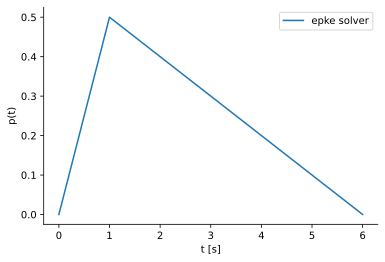

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

plt.plot(time_out, rho_imp_out/beta_eff_out, label='epke solver')
plt.xlabel('t [s]')
plt.ylabel('p(t)')
plt.legend()
plt.show()

## Plot the Results

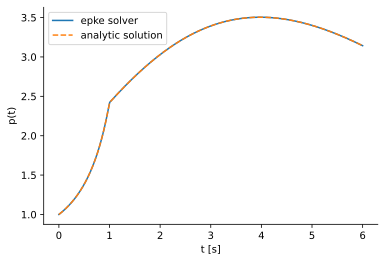

In [6]:
def analytic_soln(lambduh, t, t1, t_step, up, down, p0):
    t1_i = round(t1*t_step)
    p0_soln = p0
    p_soln = np.zeros(len(t))
    p_soln[:(t1_i+1)] = p0_soln*np.exp(-lambduh*t[:(t1_i+1)])*\
                        (1/(1 - up*t[:(t1_i+1)]))**(lambduh/up + 1)
    p_soln[(t1_i+1):] = p_soln[t1_i]*np.exp(-lambduh*(t[(t1_i+1):] - t1))*((1 - up*t1)/\
                        (1 - up*t1 + down*(t[(t1_i+1):] - t1)))**(-lambduh/down + 1)
    return p_soln

lambduh_list = np.asarray([p.decay_constant for p in precursors])
p_soln = analytic_soln(lambduh_list, time_out, t1, t_step, up, down, 1.0)

plt.plot(time_out, p_out, label='epke solver')
plt.plot(time_out, p_soln, linestyle='--', label='analytic solution')
plt.xlabel('t [s]')
plt.ylabel('p(t)')
plt.legend()
plt.show()